In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [2]:
train = pd.read_csv('./Datasets/train.csv')
test = pd.read_csv('./Datasets/test.csv')

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
y = train['label']
X = train.drop(train.columns[[0]], axis = 1)

In [5]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X = X.values
print(X)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [7]:
X.shape

(42000, 784)

In [10]:
X = X.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [11]:
print("Size of Dataset: " , len(X))

Size of Dataset:  42000


In [12]:
Cross_Validation_size = int(len(X)*0.05)
print("Validation Set Size: " , Cross_Validation_size)

Validation Set Size:  2100


In [13]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = Cross_Validation_size, random_state=2)

X_test = test

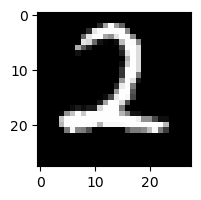

In [14]:
plt.figure(figsize=(2, 2))
plt.imshow(X_train[21][:,:,0], cmap = 'gray')
plt.show()

In [15]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Padding the images by 2 pixels since in the paper input images were 32x32
X_train = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_val = np.pad(X_val, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

# Standardization
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)
X_train = (X_train - mean_px)/(std_px)

mean_px = X_val.mean().astype(np.float32)
std_px = X_val.std().astype(np.float32)
X_val = (X_val - mean_px)/(std_px)

mean_px = X_test.mean().astype(np.float32)
std_px = X_test.std().astype(np.float32)
X_test = (X_test - mean_px)/(std_px)

# One-hot encoding the labels
Y_train = to_categorical(Y_train, num_classes = 10)
Y_val = to_categorical(Y_val, num_classes = 10)

In [16]:
print(Y_train)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


In [22]:
datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False,
        samplewise_std_normalization = False,
        zca_whitening = False,
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        horizontal_flip = False,
        vertical_flip = False)

datagen.fit(X_train)

In [23]:
variable_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 2)

In [24]:
model = Sequential([
    Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,1), kernel_regularizer=l2(0.0005), name = 'convolution_1'),
    Conv2D(filters = 32, kernel_size = 5, strides = 1, name = 'convolution_2', use_bias=False),
    BatchNormalization(name = 'batchnorm_1'),
    Activation("relu"),
    MaxPooling2D(pool_size = 2, strides = 2, name = 'max_pool_1'),
    Dropout(0.25, name = 'dropout_1'),
    Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=l2(0.0005), name = 'convolution_3'),
    Conv2D(filters = 64, kernel_size = 3, strides = 1, name = 'convolution_4', use_bias=False),
    BatchNormalization(name = 'batchnorm_2'),
    Activation("relu"),
    MaxPooling2D(pool_size = 2, strides = 2, name = 'max_pool_2'),
    Dropout(0.25, name = 'dropout_2'),
    Flatten(name = 'flatten'),    
    Dense(units = 256, name = 'fully_connected_1', use_bias=False), 
    BatchNormalization(name = 'batchnorm_3'),
    Activation("relu"),
    Dense(units = 128, name = 'fully_connected_2', use_bias=False), 
    BatchNormalization(name = 'batchnorm_4'),
    Activation("relu"),
    Dense(units = 84, name = 'fully_connected_3', use_bias=False),
    BatchNormalization(name = 'batchnorm_5'),
    Activation("relu"),
    Dropout(0.25, name = 'dropout_3'),
    Dense(units = 10, activation = 'softmax', name = 'output')
    ])

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(X_train, Y_train, epochs = 13, batch_size = 64, callbacks = [variable_learning_rate], validation_data = (X_val,Y_val))

Epoch 1/13
624/624 [==============================] - 164s 260ms/step - loss: 0.2503 - accuracy: 0.9351 - val_loss: 0.0716 - val_accuracy: 0.9848 - lr: 0.0010
Epoch 2/13
624/624 [==============================] - 170s 273ms/step - loss: 0.0931 - accuracy: 0.9781 - val_loss: 0.0558 - val_accuracy: 0.9895 - lr: 0.0010
Epoch 3/13
624/624 [==============================] - 169s 271ms/step - loss: 0.0763 - accuracy: 0.9828 - val_loss: 0.0478 - val_accuracy: 0.9895 - lr: 0.0010
Epoch 4/13
624/624 [==============================] - 184s 296ms/step - loss: 0.0679 - accuracy: 0.9835 - val_loss: 0.0458 - val_accuracy: 0.9895 - lr: 0.0010
Epoch 5/13
624/624 [==============================] - 172s 275ms/step - loss: 0.0546 - accuracy: 0.9868 - val_loss: 0.0708 - val_accuracy: 0.9848 - lr: 0.0010
Epoch 6/13
624/624 [==============================] - 166s 267ms/step - loss: 0.0522 - accuracy: 0.9878 - val_loss: 0.0455 - val_accuracy: 0.9910 - lr: 0.0010
Epoch 7/13
624/624 [==========================

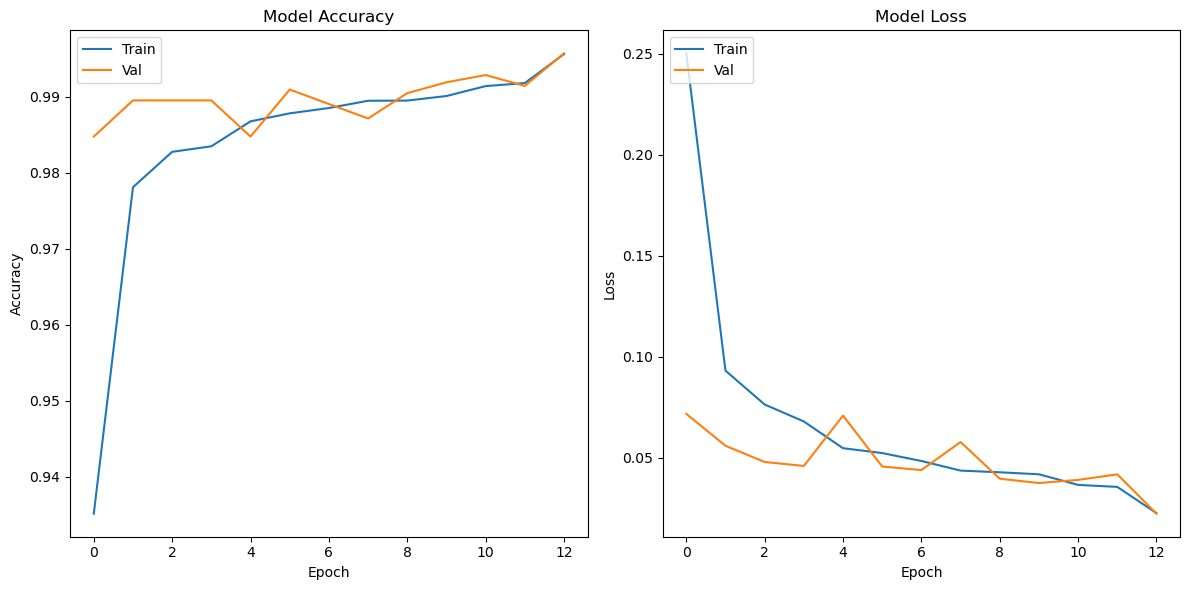

In [27]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [28]:
results = model.predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

875/875 [==============================] - 28s 32ms/step


In [30]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("predictions.csv",index=False)

In [31]:
test_labels = results

In [39]:
prediction = model.predict(X_test[[10]])
prediction_class = np.argmax(prediction, axis=1)
# prediction_classes_set.append(prediction_class)

1/1 [==============================] - 0s 35ms/step


In [ ]:
# print(prediction_classes_set)

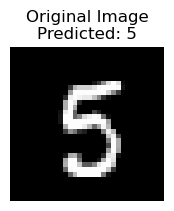

In [40]:
# prediction = model.predict(X_test[[i]])
# prediction_class = np.argmax(prediction, axis=1)
# prediction_classes_set.append(prediction_class)

plt.figure(figsize = (2,2))

plt.imshow(X_test[10].reshape(32, 32, 1), cmap = 'gray')
plt.title(f'Original Image\nPredicted: {prediction_class[0]}')
plt.axis('off')
plt.show()
    

<br></br>
<h3>To determine most vulnerable digits(out of ten digits), adding Gaussian noise to the images:</h3>

In [41]:
def gaussian_noise(X_test, sigma=1):
    """Add Gaussian noise to the dataset."""
    noise = np.random.normal(loc=0.0, scale=sigma, size=X_test.shape)
    X_noisy = X_test + noise
    return np.clip(X_noisy, 0., 1.)

In [42]:
#one-hot encoding test labels

Y_test = to_categorical(test_labels, num_classes = 10)

In [43]:
print(Y_test)

[[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]]


In [44]:
from sklearn.metrics import classification_report, accuracy_score

sigma_values = [0.4]
for sigma in sigma_values:
    X_test_noisy = gaussian_noise(X_test, sigma=sigma)
    predictions = model.predict(X_test_noisy)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(Y_test, axis=1)
        
    
    accuracy = accuracy_score(true_classes, predicted_classes)
    print(f"Accuracy with sigma={sigma}: {accuracy}")
    
    # Detailed report to find the most vulnerable digit
    print(f"Classification Report for sigma={sigma}:")
    print(classification_report(true_classes, predicted_classes))

875/875 [==============================] - 25s 29ms/step
Accuracy with sigma=0.4: 0.48575
Classification Report for sigma=0.4:
              precision    recall  f1-score   support

           0       0.96      0.82      0.89      2773
           1       0.22      1.00      0.35      3202
           2       1.00      0.48      0.65      2803
           3       1.00      0.01      0.01      2786
           4       0.89      0.66      0.75      2758
           5       0.99      0.15      0.26      2520
           6       1.00      0.00      0.01      2746
           7       0.98      0.37      0.53      2906
           8       0.52      0.94      0.67      2740
           9       0.98      0.33      0.49      2766

    accuracy                           0.49     28000
   macro avg       0.85      0.48      0.46     28000
weighted avg       0.84      0.49      0.46     28000



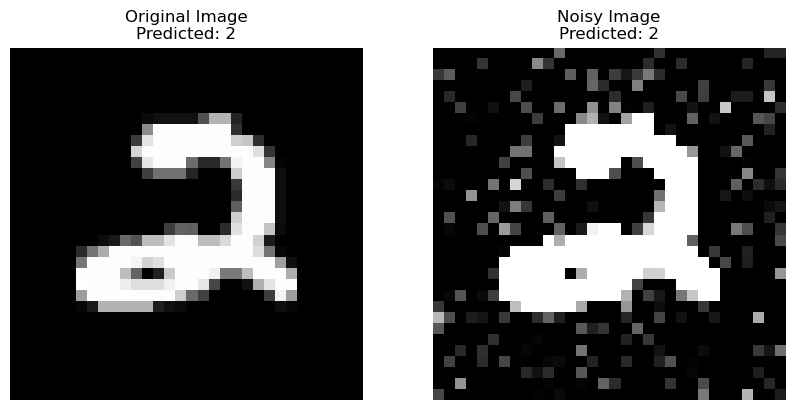

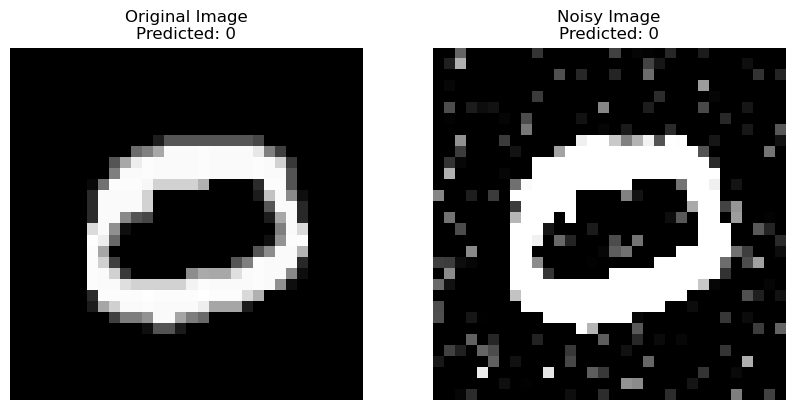

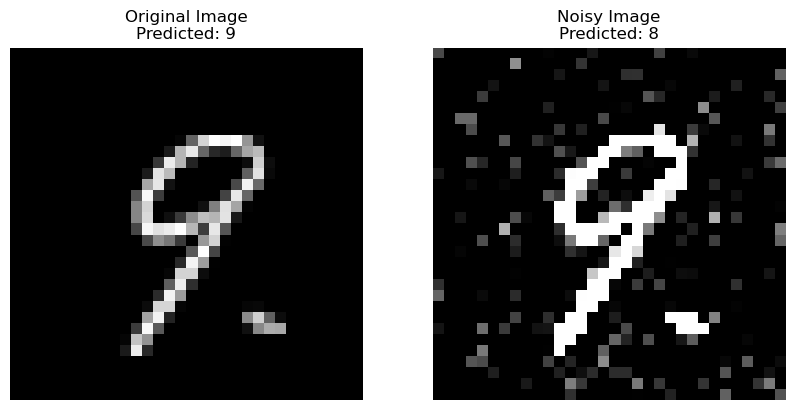

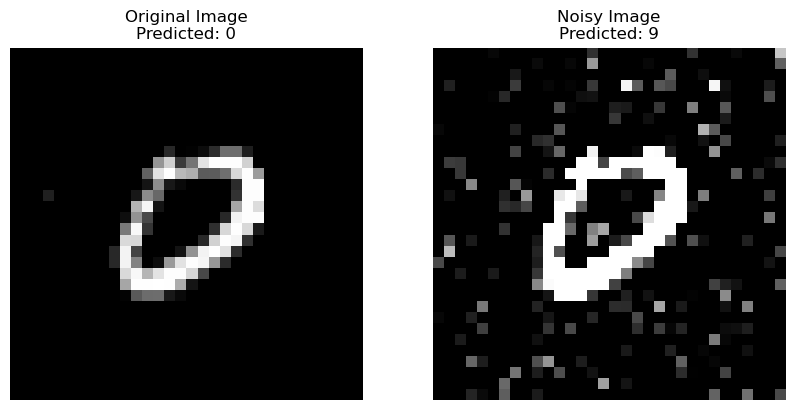

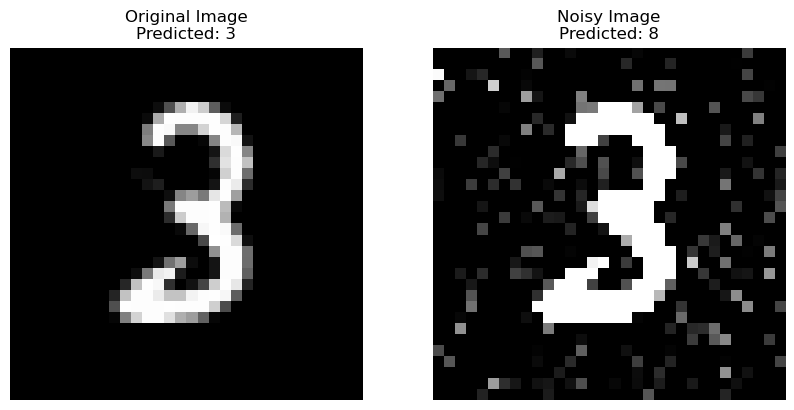

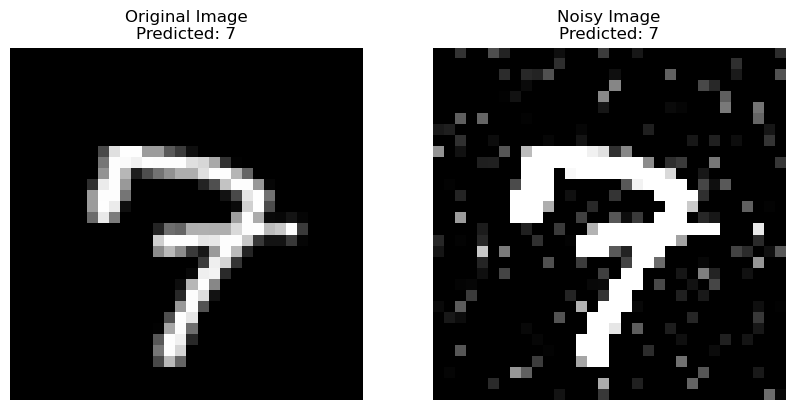

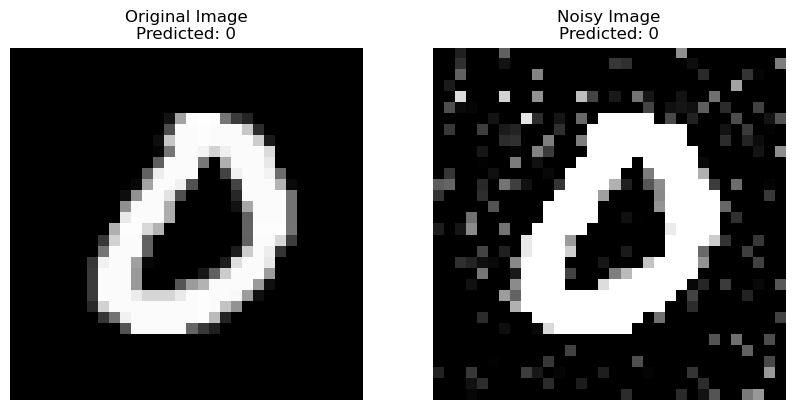

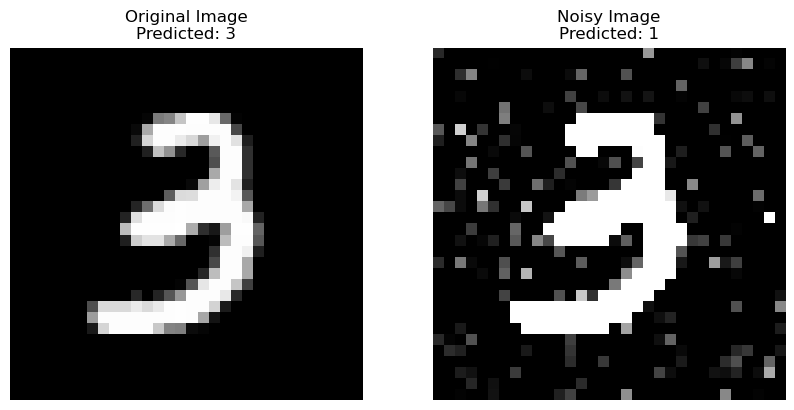

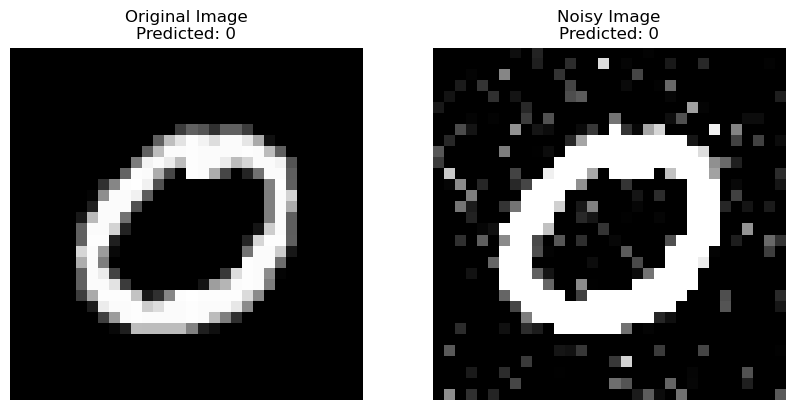

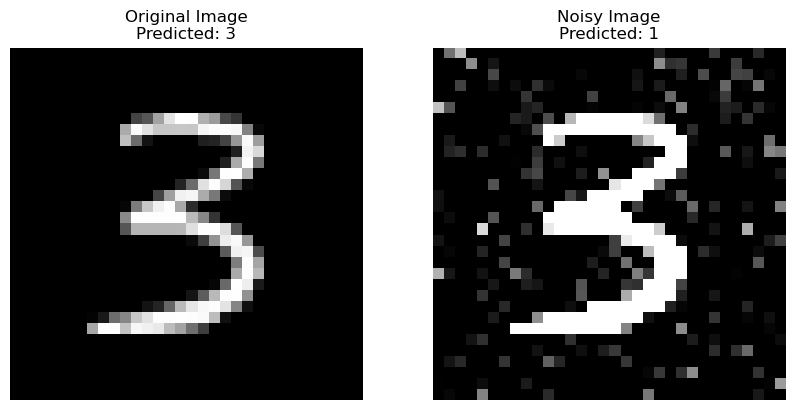

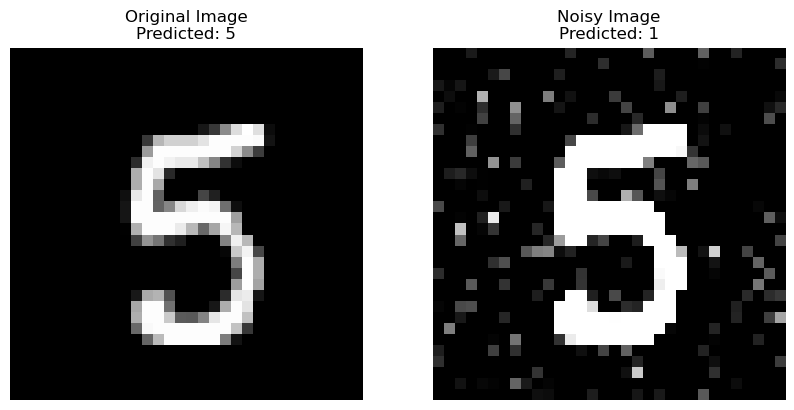

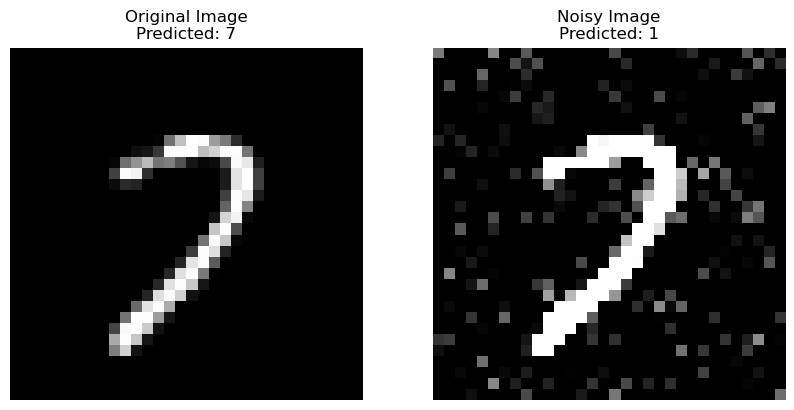

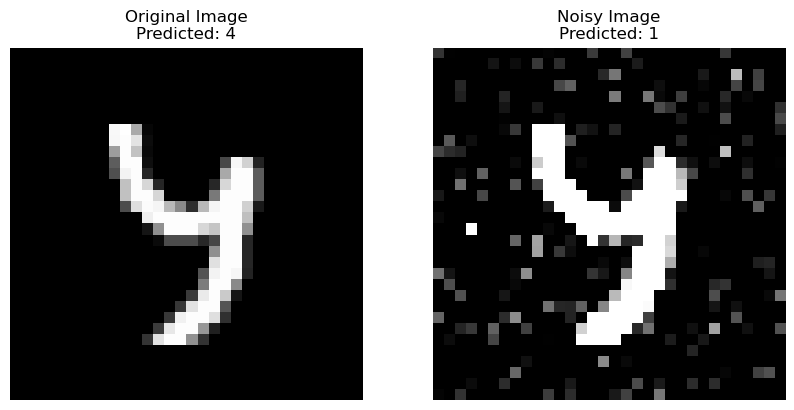

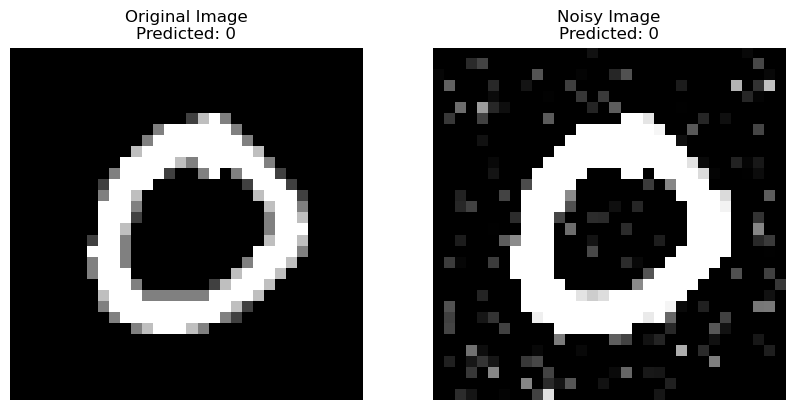

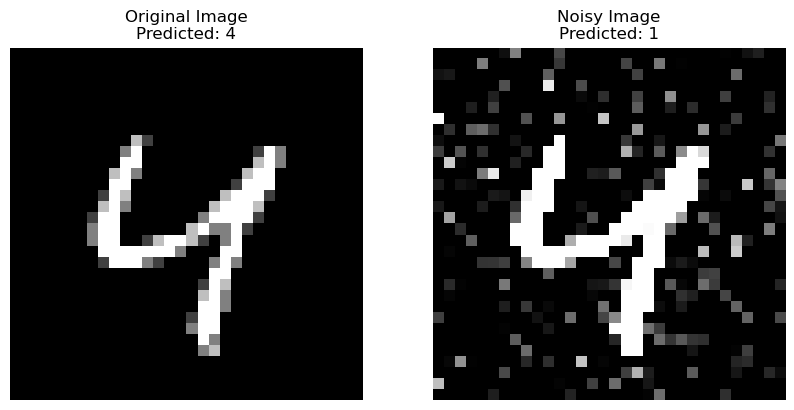

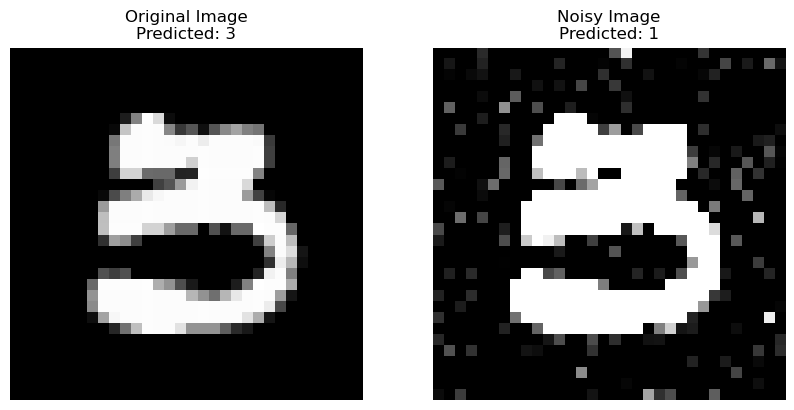

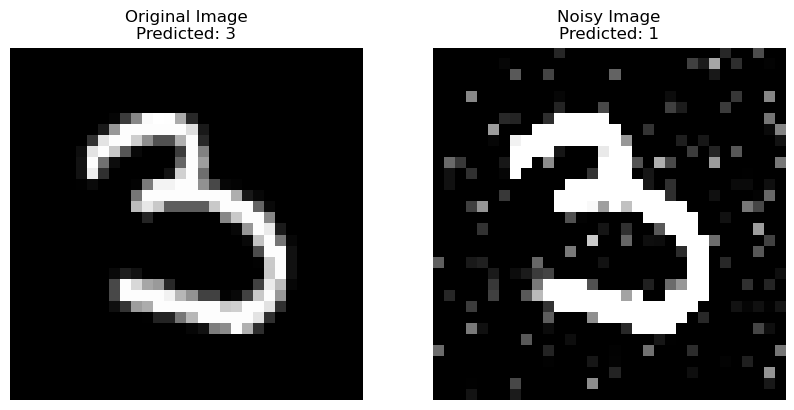

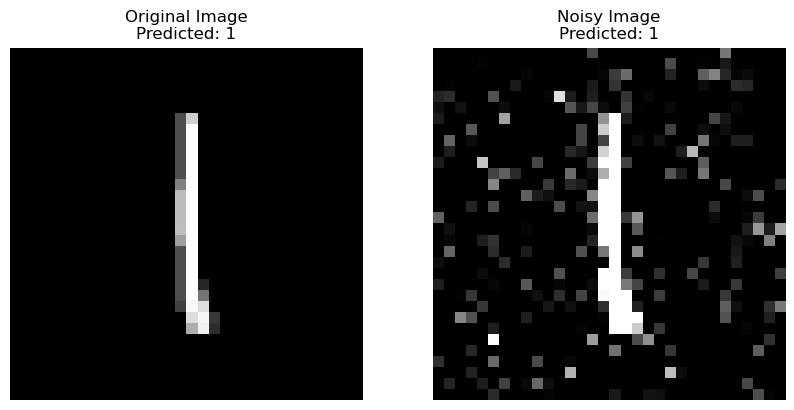

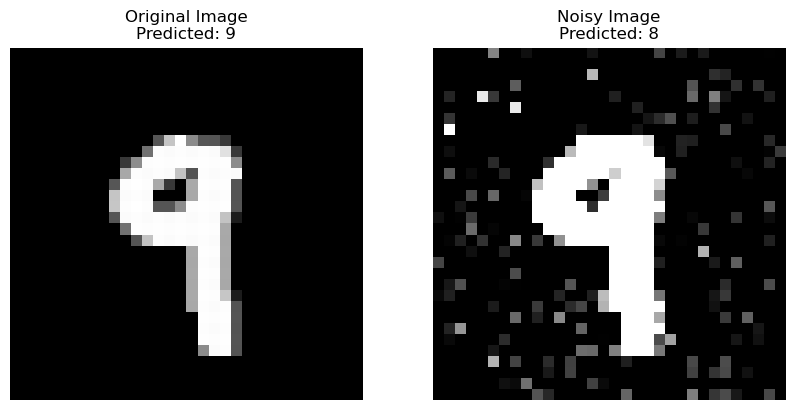

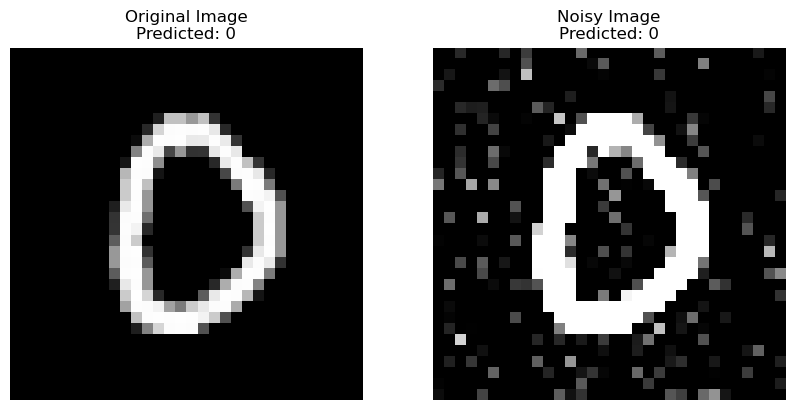

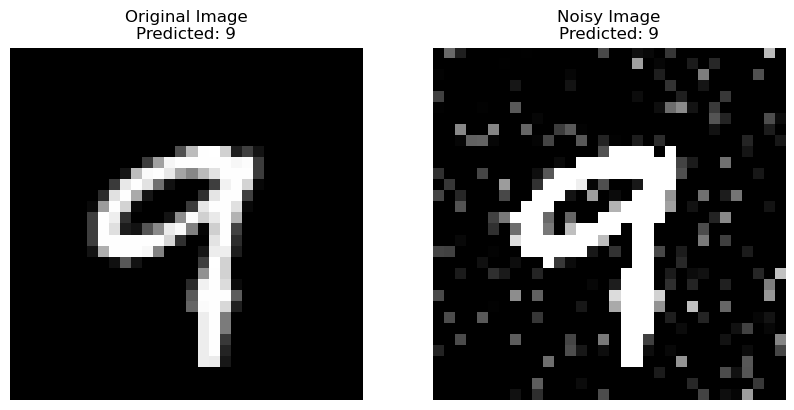

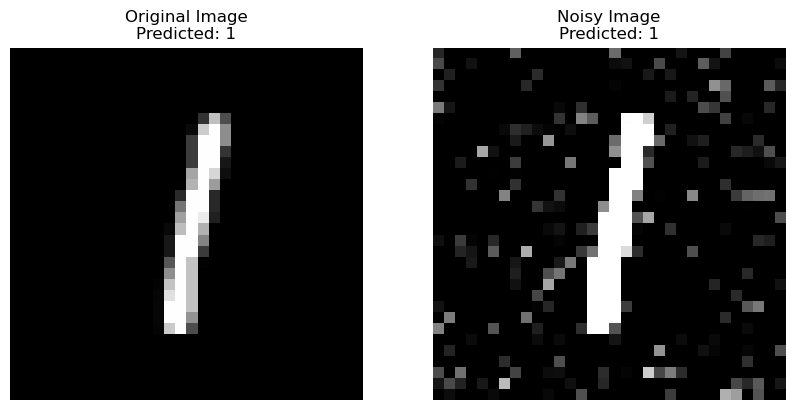

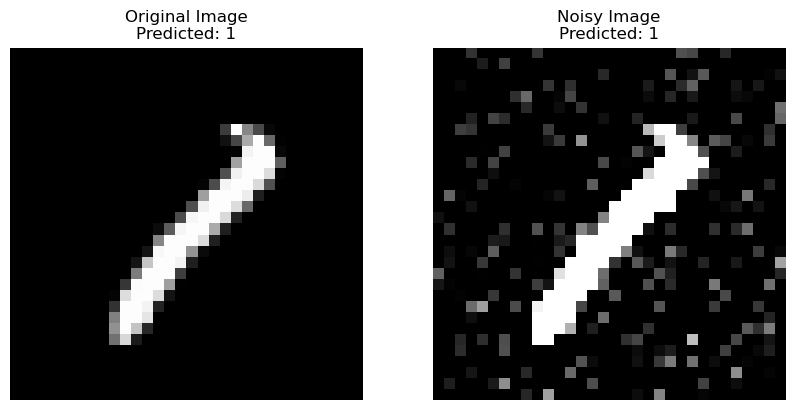

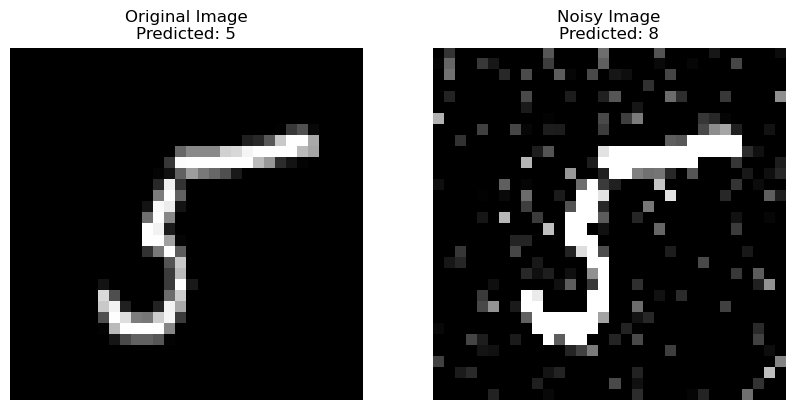

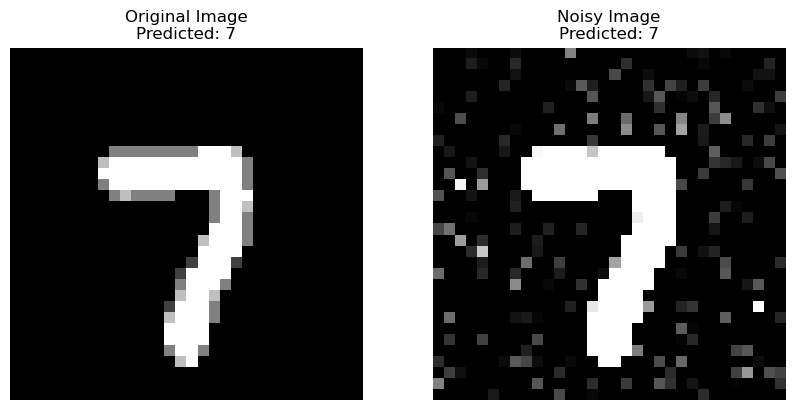

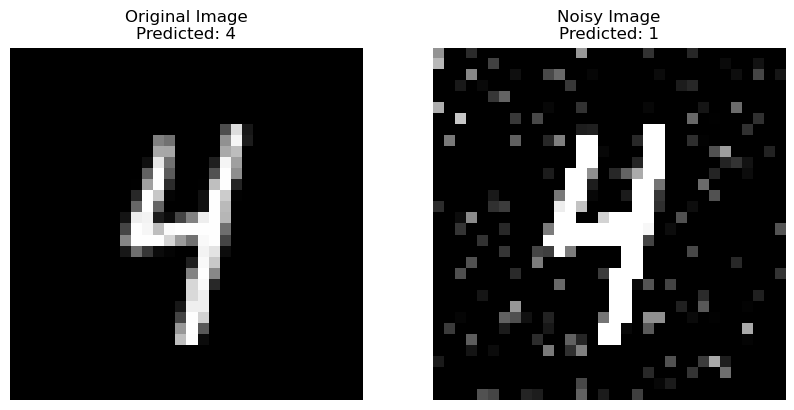

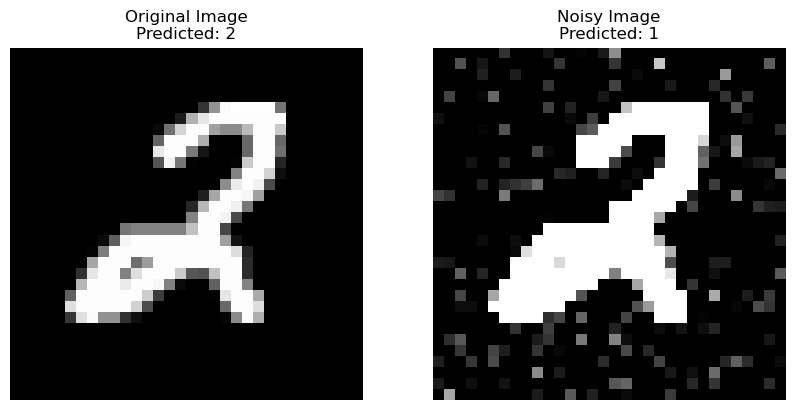

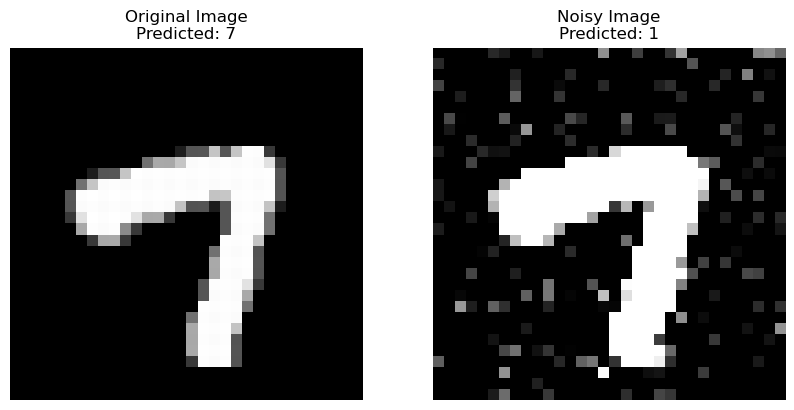

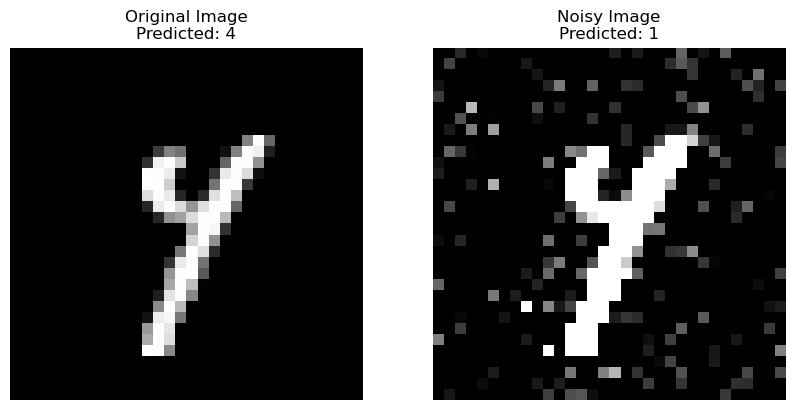

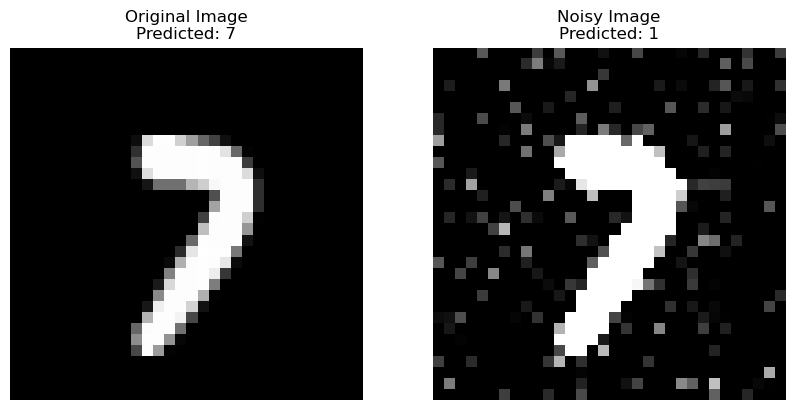

In [93]:

for i in range(30):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(X_test[i].reshape(32, 32, 1), cmap = 'gray')
    ax[0].set_title(f'Original Image\nPredicted: {true_classes[i]}')
    ax[0].axis('off')

    # Plot noisy image
    ax[1].imshow(X_test_noisy[i].reshape(32, 32, 1), cmap = 'gray')  # Adjust shape as needed for noisy image
    ax[1].set_title(f'Noisy Image\nPredicted: {predicted_classes[i]}')
    ax[1].axis('off')

    plt.show()

In [73]:
counts = np.zeros(10)

for true_class, predicted_class in zip(predicted_classes, true_classes):
    if(true_class != predicted_class):
            counts[true_class]+=1

In [90]:
np.argmax(counts)

1

<br></br>
<h2>Findings of the Experiment:</h2>

After adding noise(Sigma value is 0.4) to the predicted values, the most vulnerable digit I got is number "1".